# 1. Create toy data

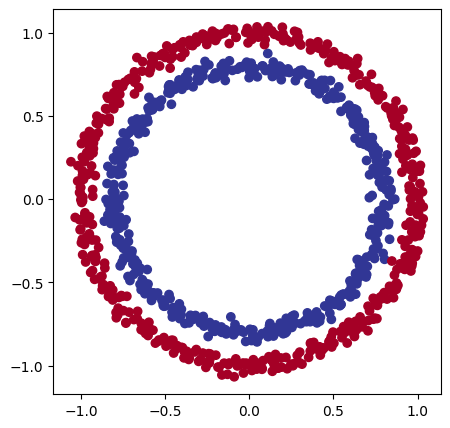

In [ ]:
from sklearn.datasets import make_circles


# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

# Visualize with a plot
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);
plt.show()

# 2. Convert to tensors and split training and test data out

In [ ]:
import torch
torch.__version__

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [ ]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

# 2. Building a model

In [ ]:
# Standard PyTorch imports
import torch
from torch import nn

print(f"PyTorch version: {torch.__version__}")

device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else torch.device("cpu")
print(f"Torch device: {device}")
if torch.cuda.is_available():
  print(f"Using CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.8.0+cu126
Torch device: cuda
Using CUDA device: Tesla T4


In [ ]:
# Create model class
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # Create 2 linear layers capable of handling the shapes of our data
    self.input_layer = nn.Linear(in_features=2, out_features=8) # 2 features like the input data
    self.output_layer = nn.Linear(in_features=8, out_features=1) # 1 result feature

  # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.output_layer(self.input_layer(x)) # Chain the layers manually

In [ ]:
# Instatiate the model and send it to the device
model_0 = CircleModelV0().to(device)
print(f"Model is on device: {next(model_0.parameters()).device}")

Model is on device: cuda:0


In [ ]:
# Use nn.Sequential instead
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=8),
    nn.Linear(in_features=8, out_features=1)
).to(device)
print(f"Model is on device: {next(model_0.parameters()).device}")

Model is on device: cuda:0


In [ ]:
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, shape: {untrained_preds.shape}")
print(f"First 10 predictions: {untrained_preds[:10]}, and first 10 labels: {y_test[:10]}")

Length of predictions: 200, shape: torch.Size([200, 1])
First 10 predictions: tensor([[ 0.1050],
        [ 0.3107],
        [-0.4647],
        [ 0.2665],
        [-0.5131],
        [-0.3872],
        [ 0.2304],
        [ 0.0668],
        [-0.4618],
        [ 0.3239]], device='cuda:0'), and first 10 labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [ ]:
# Setup loss function
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss has the sigmoid activation function built in

# Setup optimiser function
optimiser = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

# Calculate accuracy
def accuracy_fn(y_acctual, y_pred):
  correct = torch.eq(y_acctual, y_pred).sum().item();
  acc = (correct / len(y_pred)) * 100
  return acc

## Model output (logits) -> prediction probabilities -> prediction labels
Model outputs -> prediction probabilities uses an activation function, e.g sigmoid or softmax).

Prediction probabilities -> labels is done with rounding, or more likely, argmax()

In [ ]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))

# Use sigmoid function on logits to turn them in to prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_labels = torch.round(y_pred_probs)

# Can be done as y_pred_labels = torch.round(torch.sigmoud(model_0(X_test.to(device)):[5]))

y_logits[:5], y_pred_probs[:5], y_pred_labels[:5]

(tensor([[ 0.1050],
         [ 0.3107],
         [-0.4647],
         [ 0.2665],
         [-0.5131]], device='cuda:0'),
 tensor([[0.5262],
         [0.5771],
         [0.3859],
         [0.5662],
         [0.3745]], device='cuda:0'),
 tensor([[1.],
         [1.],
         [0.],
         [1.],
         [0.]], device='cuda:0'))

#Building the training loop

10:27:48 https://youtu.be/Z_ikDlimN6A?si=1B48MjBsiYC3jrIb&t=37668

In [ ]:
torch.manual_seed(seed=42)
if torch.cuda.is_available():
  torch.cuda.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


for epoch in range(epochs):
  #Set training
  model_0.train()

  #Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  #Calculate loss and accuracy
  loss = loss_fn(y_logits, y_train) #nn.BCEWithLogitsLoss expects raw logits
  acc = accuracy_fn(y_acctual=y_train, y_pred=y_pred)

  # Optimizer zero grad
  optimiser.zero_grad()

  # Loss backwards
  loss.backward()

  # Optimiser step
  optimiser.step()

  #Test
  model_0.eval()
  with torch.inference_mode():
    # Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # Test loss/accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_acctual=y_test, y_pred=test_pred)

  # Print progress
  if epoch % 10 == 0:
    print(f"Epoch: {epoch}, Loss: {loss:.5f}, Acc: {acc:.2f}%, Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0, Loss: 0.70965, Acc: 49.25%, Test Loss: 0.72314, Test Acc: 45.50%
Epoch: 10, Loss: 0.70316, Acc: 50.62%, Test Loss: 0.71566, Test Acc: 45.50%
Epoch: 20, Loss: 0.70003, Acc: 50.75%, Test Loss: 0.71126, Test Acc: 45.50%
Epoch: 30, Loss: 0.69820, Acc: 50.38%, Test Loss: 0.70822, Test Acc: 47.00%
Epoch: 40, Loss: 0.69699, Acc: 51.00%, Test Loss: 0.70593, Test Acc: 47.00%
Epoch: 50, Loss: 0.69612, Acc: 50.62%, Test Loss: 0.70413, Test Acc: 46.50%
Epoch: 60, Loss: 0.69548, Acc: 50.88%, Test Loss: 0.70269, Test Acc: 47.00%
Epoch: 70, Loss: 0.69499, Acc: 50.62%, Test Loss: 0.70152, Test Acc: 46.00%
Epoch: 80, Loss: 0.69462, Acc: 50.75%, Test Loss: 0.70056, Test Acc: 45.00%
Epoch: 90, Loss: 0.69432, Acc: 51.00%, Test Loss: 0.69976, Test Acc: 45.00%


# Check why it's borked

## Download helper function

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

## Visualise data

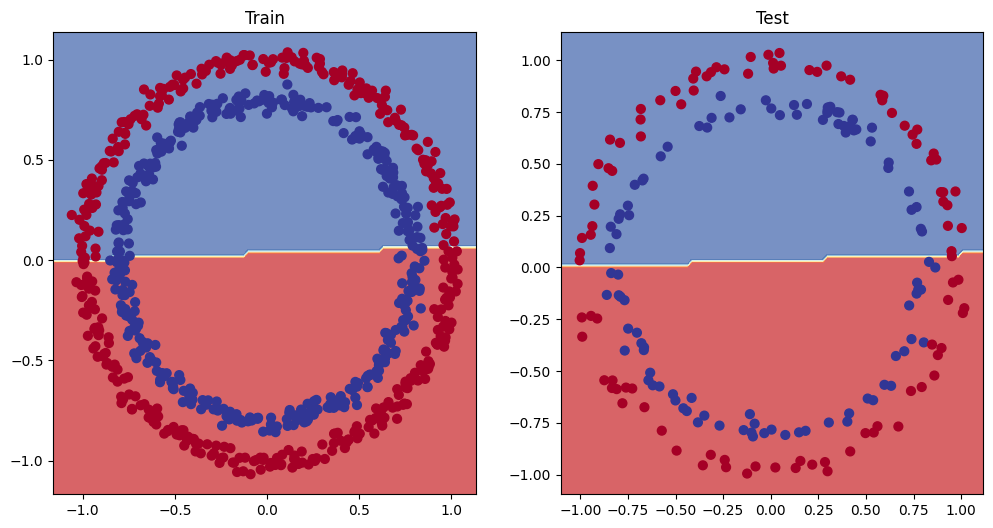

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# Update the model
11:05:37 https://youtu.be/Z_ikDlimN6A?si=rrQFy01GvWTAdJUe&t=39937

Epoch: 0, Loss: 0.69396, Acc: 50.88%, Test Loss: 0.69261, Test Acc: 51.00%
Epoch: 100, Loss: 0.69369, Acc: 50.25%, Test Loss: 0.69269, Test Acc: 50.00%
Epoch: 200, Loss: 0.69351, Acc: 50.12%, Test Loss: 0.69282, Test Acc: 49.50%
Epoch: 300, Loss: 0.69339, Acc: 50.50%, Test Loss: 0.69295, Test Acc: 49.00%
Epoch: 400, Loss: 0.69329, Acc: 50.38%, Test Loss: 0.69309, Test Acc: 48.50%
Epoch: 500, Loss: 0.69322, Acc: 49.88%, Test Loss: 0.69322, Test Acc: 49.50%
Epoch: 600, Loss: 0.69317, Acc: 49.50%, Test Loss: 0.69335, Test Acc: 53.00%
Epoch: 700, Loss: 0.69313, Acc: 49.38%, Test Loss: 0.69347, Test Acc: 50.50%
Epoch: 800, Loss: 0.69309, Acc: 50.00%, Test Loss: 0.69358, Test Acc: 51.00%
Epoch: 900, Loss: 0.69307, Acc: 50.62%, Test Loss: 0.69368, Test Acc: 47.50%


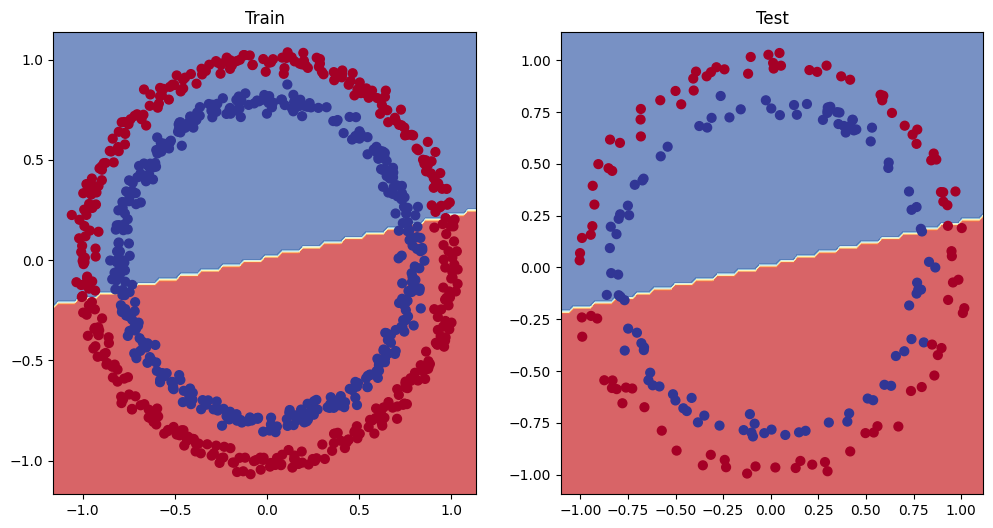

In [ ]:
# Create model
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.sequential=nn.Sequential(
        nn.Linear(in_features=2, out_features=10),
        nn.Linear(in_features=10, out_features=10),
        nn.Linear(in_features=10, out_features=1)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.sequential(x)

model_1 = CircleModelV1().to(device)

# Setup loss function
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss has the sigmoid activation function built in

# Setup optimiser function
optimiser = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

torch.manual_seed(seed=42)
if torch.cuda.is_available():
  torch.cuda.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  #Set training
  model_1.train()

  #Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  #Calculate loss and accuracy
  loss = loss_fn(y_logits, y_train) #nn.BCEWithLogitsLoss expects raw logits
  acc = accuracy_fn(y_acctual=y_train, y_pred=y_pred)

  # Optimizer zero grad
  optimiser.zero_grad()

  # Loss backwards
  loss.backward()

  # Optimiser step
  optimiser.step()

  #Test
  model_1.eval()
  with torch.inference_mode():
    # Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # Test loss/accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_acctual=y_test, y_pred=test_pred)

  # Print progress
  if epoch % (epochs/10) == 0:
    print(f"Epoch: {epoch}, Loss: {loss:.5f}, Acc: {acc:.2f}%, Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

# Can it learn anything?

X_lr_train: torch.Size([80, 1]), y_lr_train: torch.Size([80, 1])
Epoch: 0, Loss: 0.75986, Test Loss: 0.91103
Epoch: 100, Loss: 0.02858, Test Loss: 0.00081
Epoch: 200, Loss: 0.02533, Test Loss: 0.00209
Epoch: 300, Loss: 0.02137, Test Loss: 0.00305
Epoch: 400, Loss: 0.01964, Test Loss: 0.00341
Epoch: 500, Loss: 0.01940, Test Loss: 0.00387
Epoch: 600, Loss: 0.01903, Test Loss: 0.00379
Epoch: 700, Loss: 0.01878, Test Loss: 0.00381
Epoch: 800, Loss: 0.01840, Test Loss: 0.00329
Epoch: 900, Loss: 0.01798, Test Loss: 0.00360


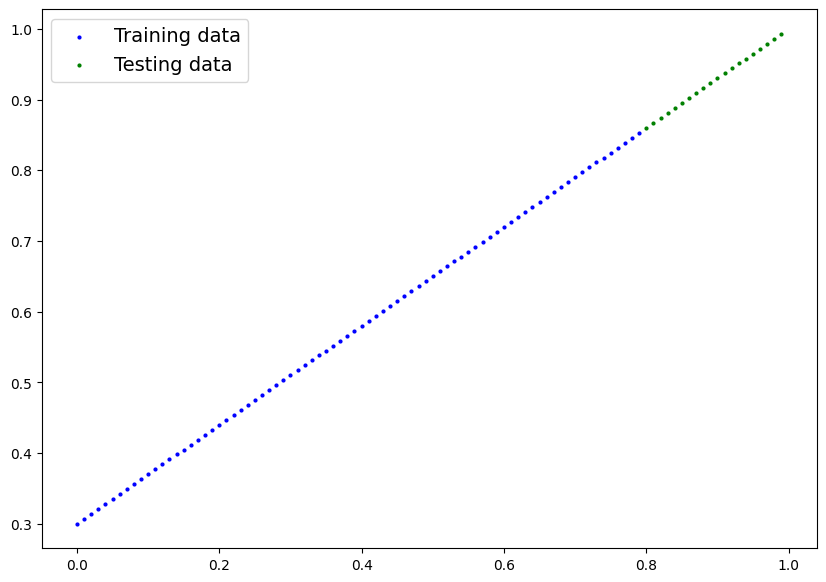

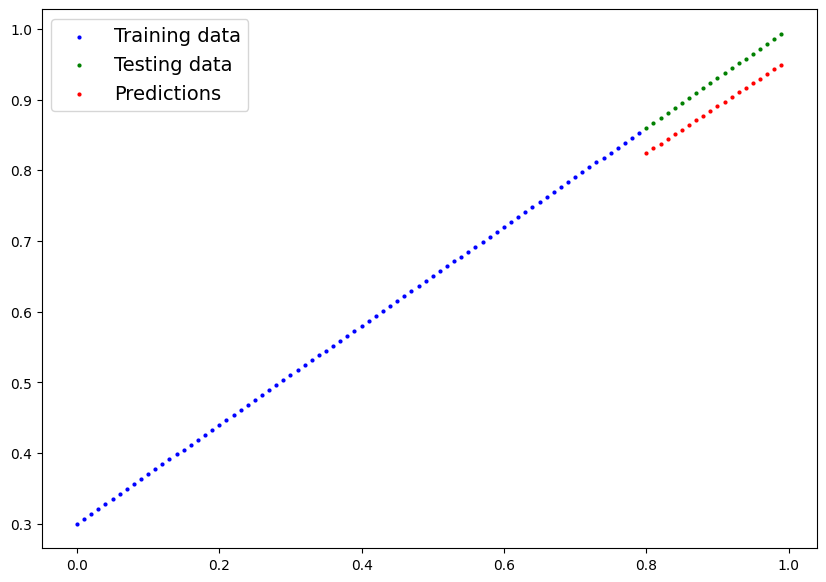

In [ ]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.01

X_lr_data = torch.arange(start, end, step).unsqueeze(dim=1)
y_lr_data = weight * X_lr_data + bias

train_split = int(0.8*len(X_lr_data))
X_lr_train, y_lr_train = X_lr_data[:train_split], y_lr_data[:train_split]
X_lr_test, y_lr_test = X_lr_data[train_split:], y_lr_data[train_split:]

print(f"X_lr_train: {X_lr_train.shape}, y_lr_train: {y_lr_train.shape}")

plot_predictions(train_data=X_lr_train,
    train_labels=y_lr_train,
    test_data=X_lr_test,
    test_labels=y_lr_test
);

model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

# Setup loss function
loss_fn = nn.L1Loss()

# Setup optimiser function
optimiser = torch.optim.SGD(params=model_2.parameters(), lr=0.01)

torch.manual_seed(seed=42)
if torch.cuda.is_available():
  torch.cuda.manual_seed(42)

epochs = 1000

X_lr_train, y_lr_train = X_lr_train.to(device), y_lr_train.to(device)
X_lr_test, y_lr_test = X_lr_test.to(device), y_lr_test.to(device)

for epoch in range(epochs):
  #Set training
  model_2.train()

  #Forward pass
  y_pred = model_2(X_lr_train)

  #Calculate loss and accuracy
  loss = loss_fn(y_pred, y_lr_train) #nn.BCEWithLogitsLoss expects raw logits
  acc = accuracy_fn(y_acctual=y_lr_train, y_pred=y_pred)

  # Optimizer zero grad
  optimiser.zero_grad()

  # Loss backwards
  loss.backward()

  # Optimiser step
  optimiser.step()

  #Test
  model_2.eval()
  with torch.inference_mode():
    # Forward pass
    test_pred = model_2(X_lr_test)

    # Test loss/accuracy
    test_loss = loss_fn(test_pred, y_lr_test)

  # Print progress
  if epoch % (epochs/10) == 0:
    print(f"Epoch: {epoch}, Loss: {loss:.5f}, Test Loss: {test_loss:.5f}")

# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_lr_test)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_lr_train.cpu(),
                 train_labels=y_lr_train.cpu(),
                 test_data=X_lr_test.cpu(),
                 test_labels=y_lr_test.cpu(),
                 predictions=y_preds.cpu());

# The missing piece: non-linearity

## Recreate circular data

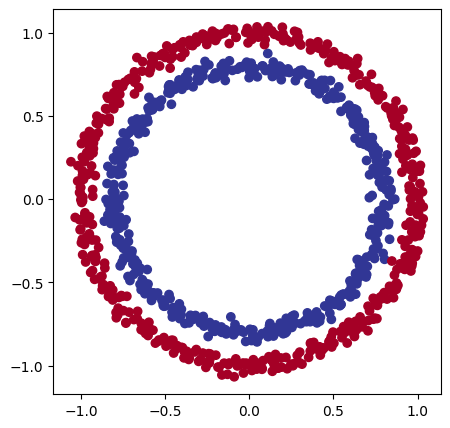

In [ ]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch import nn

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

plt.figure(figsize=(5,5))
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);
plt.show()

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Build model with non-linear activation functions

Epoch: 0, Loss: 0.69753, Acc: 50.00%, Test Loss: 0.69705, Test Acc: 50.00%
Epoch: 100, Loss: 0.68267, Acc: 53.62%, Test Loss: 0.68571, Test Acc: 52.50%
Epoch: 200, Loss: 0.65956, Acc: 62.12%, Test Loss: 0.66771, Test Acc: 58.00%
Epoch: 300, Loss: 0.56558, Acc: 97.25%, Test Loss: 0.58762, Test Acc: 92.50%
Epoch: 400, Loss: 0.46129, Acc: 69.00%, Test Loss: 0.51314, Test Acc: 57.00%
Epoch: 500, Loss: 0.32316, Acc: 85.75%, Test Loss: 0.40101, Test Acc: 73.50%
Epoch: 600, Loss: 0.07445, Acc: 99.88%, Test Loss: 0.10600, Test Acc: 99.50%
Epoch: 700, Loss: 0.03455, Acc: 100.00%, Test Loss: 0.05823, Test Acc: 100.00%
Epoch: 800, Loss: 0.02074, Acc: 100.00%, Test Loss: 0.03943, Test Acc: 100.00%
Epoch: 900, Loss: 0.01449, Acc: 100.00%, Test Loss: 0.03040, Test Acc: 100.00%


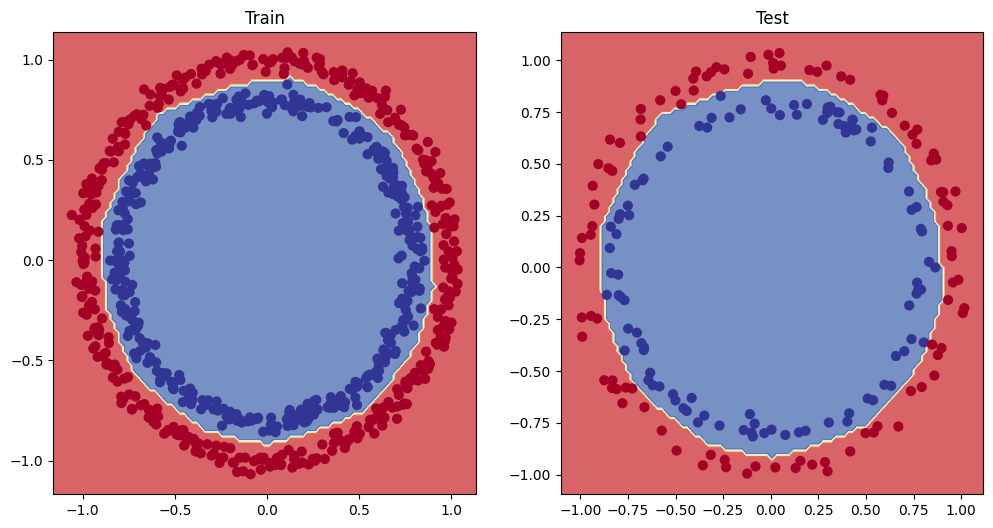

In [ ]:
torch.manual_seed(seed=42)
if torch.cuda.is_available():
  torch.cuda.manual_seed(42)

model_3 = nn.Sequential(
    nn.Linear(in_features=2, out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16, out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16, out_features=1)
).to(device)

epochs = 1000
lr=0.3

# Setup loss function
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss has the sigmoid activation function built in

# Setup optimiser function
optimiser = torch.optim.SGD(params=model_3.parameters(), lr=lr)

# Calculate accuracy
def accuracy_fn(y_acctual, y_pred):
  correct = torch.eq(y_acctual, y_pred).sum().item();
  acc = (correct / len(y_pred)) * 100
  return acc

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  #Set training
  model_3.train()

  #Forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  #Calculate loss and accuracy
  loss = loss_fn(y_logits, y_train) #nn.BCEWithLogitsLoss expects raw logits
  acc = accuracy_fn(y_acctual=y_train, y_pred=y_pred)

  # Optimizer zero grad
  optimiser.zero_grad()

  # Loss backwards
  loss.backward()

  # Optimiser step
  optimiser.step()

  #Test
  model_3.eval()
  with torch.inference_mode():
    # Forward pass
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # Test loss/accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_acctual=y_test, y_pred=test_pred)

  # Print progress
  if epoch % (epochs/10) == 0:
    print(f"Epoch: {epoch}, Loss: {loss:.5f}, Acc: {acc:.2f}%, Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

# Multiclass classification

12:42:51 https://youtu.be/Z_ikDlimN6A?si=XUS-S5wcCFFVmgp6&t=45753

* 1 Output per class
* Softmax instead of Sigmoid
* Cross Entropy Loss instead of Binary Cross Entropy Loss

## Creating toy multiclass data set

PyTorch version: 2.8.0+cu126
Torch device: cuda
Using CUDA device: Tesla T4
helper_functions.py already exists, skipping download


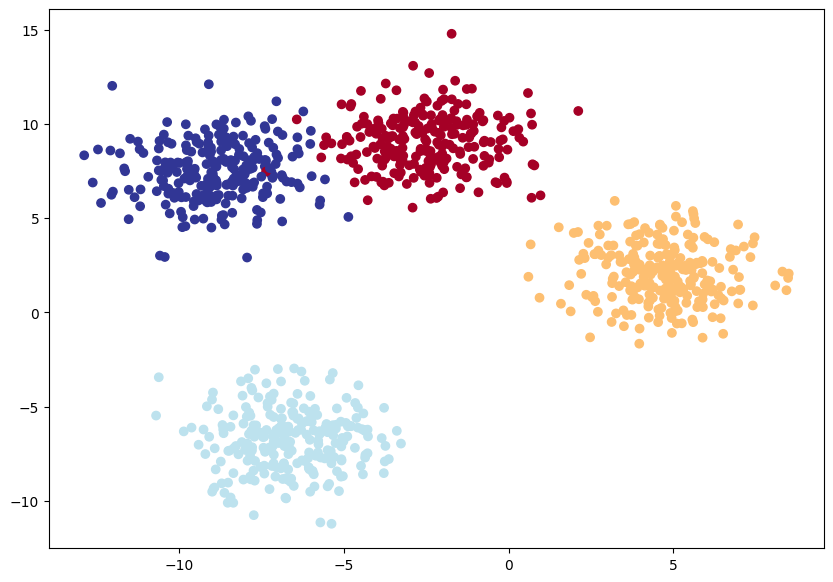

In [ ]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import requests
from pathlib import Path

print(f"PyTorch version: {torch.__version__}")

device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else torch.device("cpu")
print(f"Torch device: {device}")
if torch.cuda.is_available():
  print(f"Using CUDA device: {torch.cuda.get_device_name(0)}")

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

NUM_CLASSES = 4
NUM_FEATURES = 2
NUM_SAMPLES = 1000
CLUSTER_STD_DEV=1.5
RANDOM_SEED = 42
EPOCHS = 100
LR = 0.1
TRAIN_TEST_SPLIT_RATIO=0.2

X_blob, y_blob = make_blobs(n_samples=NUM_SAMPLES,
                              n_features=NUM_FEATURES,
                              centers=NUM_CLASSES,
                              cluster_std=CLUSTER_STD_DEV,
                              random_state=RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.long)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=TRAIN_TEST_SPLIT_RATIO,
                                                                        random_state=RANDOM_SEED)

plt.figure(figsize=(10,7))
#X_blob is 1000 x,y coordinates, so plot x as the zero element from all 1000 entries, and plot y as the first element from all 1000 entries
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)
plt.show()

# Move data to device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

## Building a multi-class classifification model

Epoch: 0, Loss: 1.15883, Acc: 40.38%, Test Loss: 1.07554, Test Acc: 48.00%
Epoch: 10, Loss: 0.64476, Acc: 96.75%, Test Loss: 0.66069, Test Acc: 97.50%
Epoch: 20, Loss: 0.42535, Acc: 98.50%, Test Loss: 0.43074, Test Acc: 100.00%
Epoch: 30, Loss: 0.25294, Acc: 99.12%, Test Loss: 0.24508, Test Acc: 99.50%
Epoch: 40, Loss: 0.11232, Acc: 99.25%, Test Loss: 0.10229, Test Acc: 99.50%
Epoch: 50, Loss: 0.06627, Acc: 99.25%, Test Loss: 0.05848, Test Acc: 99.50%
Epoch: 60, Loss: 0.05068, Acc: 99.25%, Test Loss: 0.04293, Test Acc: 99.50%
Epoch: 70, Loss: 0.04300, Acc: 99.25%, Test Loss: 0.03491, Test Acc: 99.50%
Epoch: 80, Loss: 0.03836, Acc: 99.25%, Test Loss: 0.02988, Test Acc: 99.50%
Epoch: 90, Loss: 0.03525, Acc: 99.25%, Test Loss: 0.02663, Test Acc: 99.50%


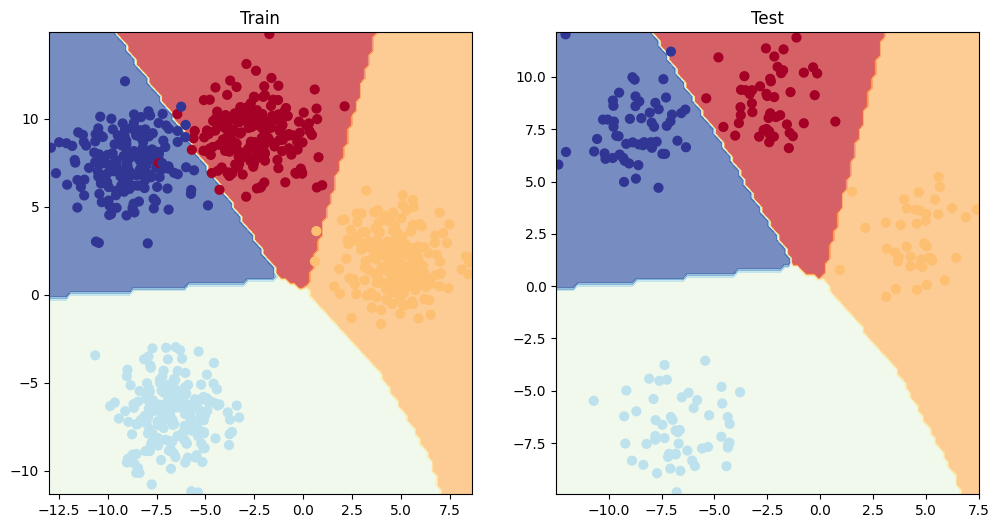

In [ ]:
torch.manual_seed(seed=42)
if torch.cuda.is_available():
  torch.cuda.manual_seed(42)

def accuracy_fn(y_acctual, y_pred):
  correct = torch.eq(y_acctual, y_pred).sum().item();
  acc = (correct / len(y_pred)) * 100
  return acc

class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """Initialises multi-class classification model.

    Args:
      input_features(int): Number of input features to the model
      output_features(int): Number of output features to the model (number of classes)
      hidden_units(int): Number of hidden units between layers, default 8

    Returns:
    Example:
    """
    super().__init__()

    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features),
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=NUM_FEATURES, output_features=NUM_CLASSES).to(device)

# Setup loss function
loss_fn = nn.CrossEntropyLoss()

# Setup optimiser function
optimiser = torch.optim.SGD(params=model_4.parameters(), lr=LR)

for epoch in range(EPOCHS):
  #Set training
  model_4.train()

  #Forward pass
  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  #Calculate loss and accuracy
  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_acctual=y_blob_train, y_pred=y_pred)

  # Optimizer zero grad
  optimiser.zero_grad()

  # Loss backwards
  loss.backward()

  # Optimiser step
  optimiser.step()

  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_acctual=y_blob_test, y_pred=test_preds)

  # Print progress
  if epoch % (EPOCHS/10) == 0:
    print(f"Epoch: {epoch}, Loss: {loss:.5f}, Acc: {acc:.2f}%, Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)
plt.show()

# More Classification Metrics

* Accuracy - %age samples correct
* Precision
* Recall
* F1-score - combines precision and recall
* Confusion matrix
* Classification report

https://www.youtube.com/watch?v=Z_ikDlimN6A&t=49845s

Accuracy is not the best on data with imbalaced classes.

Increased precision reduces false positives. Increased recall reduces false negatives. High precision reduces recall and vice versa.

F1 score is a good overall metric as it combines precision and recall.

In [ ]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==1.8.2 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=NUM_CLASSES).to(device)

# Calculate accuracy
torchmetrics_accuracy(test_preds, y_blob_test)

tensor(0.9950, device='cuda:0')